# Progetto Visualizzazione Scientifica

### Introduzione

La ricerca ha l'obiettivo di analizzare le scuole dal punto di vista dell'inserimento nelle città; ovvero come essere dialogano con l'infrastruttura di trasporto e con l'ambiente circostante.
Le analisi si articolano attraverso i seguenti temi:
- la raggiungibilità delle scuole mediante i mezzi di trasporto pubblici disponibili nella città. 
- l'ambiente in cui si trova la scuola, ovvero la vicinanza della scuola a fonti inquinanti di vario tipo, cimiteri, discariche, ecc.;
questo tema può anche diventare occasione di discutere la qualità e la distribuzione degli agenti inquinanti da un punto di vista pratico, ovvero legato ai luoghi che frequentiamo quotidianamente, piuttosto che da un punto di vista puramente scientifico.
- il superamento delle barriere architettoniche, ovvero la presenza di accorgimenti strutturali che consentono anche a persone con disabilità di fruire in modo completo dell'edificio e dei suoi servizi;
quest'ultimo punto consente di completare il tema della raggiungibilità.

La ricerca porterà le diverse regioni e provincie italiane a confronto, con lo scopo di evidenziare le zone di maggior criticità; queste saranno analizzate in modo approfondito, per identificare nel dettaglio le problematiche e come esse si sono evolute nel tempo.

I dati sono forniti dal ministero dell'istruzione alla seguente pagina: https://dati.istruzione.it/opendata/opendata/catalogo/elements1/?area=Edilizia%20Scolastica


# Raggiungibilità

- scuolabus
- urbani
- interurbani
- ferroviari


INTRODUZIONE:
- 1: Semplice line-chart in cui descriviamo l'andamento della percentuale di scuole raggiungibili per ogni tipo di mezzo pubblico; in questo modo per ogni anno vediamo in percentuale quante scuole sono raggiungibili con un certo mezzo, e vediamo nel tempo se questa percentuale è cambiata o meno; questo grafico ci permette di comprendere quali sono i mezzi presumibilmente più utilizzati per raggiungere le scuole.
- 2: Una cartina epr ogni mezzo, in cui per ogni regione vediamo la percentuale di scuole raggiungibili con quel mezzo; in questo modo possiamo capire come sono distribuiti i mezzi nelle regioni, se si tratta quindi di mezzi utilizzati in modo diffuso in tutta italia o se si concentrano in alcune regioni; la scala dei colori dovrebbe rimanere la stessa per tutte le cartine in modo da mantenere consistenza tra i valori.

barchart tipo mezzo o tipo scuola 
Probabilmente da queste due prime cartine non ricaveremo granché, ma credo abbia senso per farsi un idea generale


SITUAZIONE GENERALE:
- 3: si potrebbero fare delle cartine "riassuntive" che fotografano la situazione generale delle regioni: per ogni regione calcoliamo la percentuale di sucole raggiungibili con almeno un mezzo; potremmo fare una cartina per ogni "numero di mezzi minimi", quindi la cartina delle scuole raggiungibili da un mezzo, quella delle scuole raggiungibili da almeno 2 mezzi e così via. Queste cartine riassuntive dovrebbero consentirci di identificare la regione peggiore e quindi prenderla come caso critico da analizzare in modo più specifico.
Come cartina riassuntiva si potrebbe anche usare, anzichè la percentuale di scuole, il numero di "collegamenti", ovvero se una scuola è raggiunta da 3 mezzi allora dà 3 collegamenti, e calcoliamo la percentuale contando che ogni scula potrebbe avere massimo tot collegamenti; in questo modo potremmo fare un'unica cartina, anche se forse la cartina delle scuole raggiunte da almeno un mezzo potrebbe avere più senso, perché credo sia importante che ci sia almeno un mezzo, piuttosto che se ci sono tanti mezzi per raggiungere una scuola


REGIONE CRITICA:
- 4: line chart in cui vediamo nel tempo se è cambiata la percentuale di scuole raggiunte da almeno un mezzo
- 5: cartina in cui vediamo come la percentuale è distribuita nelle province; se c'è una provincia particolarmente critica potremmo andare a vedere la distribuzione comunale.

### import librerie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.text import Text
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import geopandas as gpd
import mapclassify as mc
from shapely.geometry import Polygon, Point

data_dir = "./dataset/"
img_dir = "./img/"

## Colormap

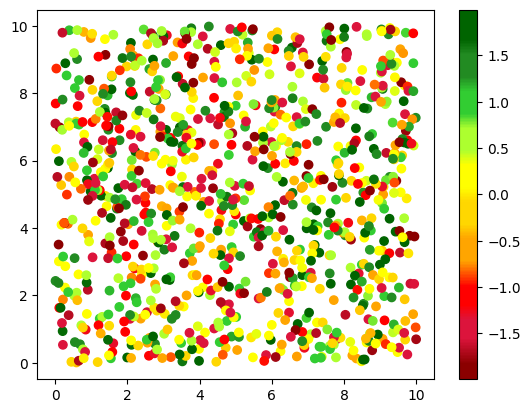

In [2]:
def make_colormap(seq):
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb

cm = make_colormap([c('darkred'), 0.04, c('darkred'), c('crimson'), 0.11, c('crimson'), 0.16, c('crimson'), c('r'), 0.20,
                    c('r'), 0.25, c('r'), c('orange'), 0.32, c('orange'), 0.38, c('orange'), c('gold'), 0.42, c('gold'), 0.48,
                    c('gold'), c('yellow'), 0.52, c('yellow'), 0.58, c('yellow'), c('greenyellow'), 0.62, c('greenyellow'),
                    0.68, c('greenyellow'), c('limegreen'), 0.72, c('limegreen'), 0.78, c('limegreen'), c('forestgreen'), 0.82,
                    c('forestgreen'), 0.88,c('forestgreen'), c('darkgreen'), 0.92, c('darkgreen')])

N = 1000
array_dg = np.random.uniform(0, 10, size=(N, 2))
colors = np.random.uniform(-2, 2, size=(N,))
plt.scatter(array_dg[:, 0], array_dg[:, 1], c=colors, cmap=cm)
plt.colorbar()
plt.show()

## Funzioni utili ( private )

In [3]:
# Funzione che modifica i nomi delle colonne di "da_modificare" con i nomi delle corrispondenti colonne di "base"
def make_consistent(base, da_modificare):
    for i in range(min(base.columns.size, da_modificare.columns.size)):
        # check if columns name are equal
        if(base.columns[i] != da_modificare.columns[i]):
            # rename column
            da_modificare.rename(columns = {da_modificare.columns[i]:base.columns[i]}, inplace=True)

# Funzione che verifica che due dataset abbiano lo stesso numero di colonne e con gli stessi nomi 
def check_same_shape(a, b):
    size = min(a.columns.size, b.columns.size)
    return np.all(a.columns[:size] == b.columns[:size])

def get_province_by_region(regione, elenco_province):
    return elenco_province[elenco_province.regione == regione].sigla.to_numpy()
def get_scuole_by_province(province, elenco_scuole):
    return elenco_scuole[elenco_scuole.SIGLAPROVINCIA.isin(province)]

## Funzioni utili ( public )

In [4]:
def get_scuole_by_region(regione, elenco_scuole, elenco_province):
    return get_scuole_by_province(get_province_by_region(regione, elenco_province), elenco_scuole)


def cartina(get_dati_function, regioni, title):
    # add data to italy dataset
    regioni['DATA'] = regioni.DEN_REG.apply(lambda x: get_dati_function(x))
    
    # get no data regions
    nodata = regioni[regioni.DATA == 0]
    regioni = regioni.drop(regioni[regioni.DATA == 0].index)
    
    # set up cartina
    fig, ax = plt.subplots(1, figsize=(8, 16))
    ax.set_axis_off()
    plt.title(title)
    cmap=cm
    bins_size=11
    
    # bins
    bins = np.linspace(0, 100, bins_size)
    
    #plot
    regioni.plot(column='DATA', cmap=cmap, ax=ax,
             edgecolor='black', linewidth=1, 
             scheme="User_Defined", 
             classification_kwds=dict(bins=bins),
             legend=True, legend_kwds={'title': "legend"} )
    
 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    
    patches = []
    for i in range(bins_size - 1):
        patches.append(mpatches.Patch(color=sm.to_rgba(bins[i]),
                                      label=(str(round(bins[i])) + ' - ' + str(round(bins[i + 1])) + " %") ) )

    patches.append(mpatches.Patch(color='none'))
    patches.append(mpatches.Patch(color='lightgray', label='no data'))
    ax.legend(handles=patches, loc="best", prop={'size':9})
    nodata.plot(color='lightgray', ax=ax, edgecolor='black', linewidth=1)


def autolabel(rects):
    for rect in rects:
        height = round(rect.get_height())
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 10),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=15)    


shape_regioni = gpd.read_file(filename=(data_dir + 'regioni_shape/regioni.shp'))

# Import DataSet

In [5]:
# ***************************** #
# ********* ELENCO ************ # 
# ***************************** #

elenco_scuole = pd.read_csv(data_dir + "elenco_scuole_italia.csv")

elenco_province = pd.read_csv(data_dir + "province.csv", encoding='latin-1')
elenco_regioni = elenco_province.regione.unique()


# ***************************** #
# ****** RAGGIUNGIBILITÀ ****** # 
# ***************************** #
t_1516 = pd.read_csv(data_dir + "trasporti_italia_1516.csv")
t_1718 = pd.read_csv(data_dir + "trasporti_italia_1718.csv")
t_1819 = pd.read_csv(data_dir + "trasporti_italia_1819.csv")
t_2021 = pd.read_csv(data_dir + "trasporti_italia_2021.csv")
t_2122 = pd.read_csv(data_dir + "trasporti_italia_2122.csv")

# MODIFICHE
# drop last column ( "ALTRO", difficile da analizzare)
t_1516.drop(columns=[t_1516.columns[t_1516.columns.size - 1]], inplace=True)
t_1718.drop(columns=[t_1718.columns[t_1718.columns.size - 1]], inplace=True)
t_1819.drop(columns=[t_1819.columns[t_1819.columns.size - 1]], inplace=True)
t_2021.drop(columns=[t_2021.columns[t_2021.columns.size - 1]], inplace=True)
t_2122.drop(columns=[t_2122.columns[t_2122.columns.size - 1]], inplace=True)
# le annate 2021 e 2122 hanno in più una colonna alla fine relativa alla presenza di piste ciclabili

# modifica nomi degli attributi 
make_consistent(t_2021, t_1516)
make_consistent(t_2021, t_1718)
make_consistent(t_2021, t_1819)

#####################################################################################

print('SCHEMA DATASET RAGGIUNGIBILITÀ', t_1819.columns)
print("\n\n")
print('SCHEMA ELENCO SCUOLE', elenco_scuole.columns)
print("\n\n")
print('SCHEMA province', elenco_province.columns)

SCHEMA DATASET RAGGIUNGIBILITÀ Index(['ANNOSCOLASTICO', 'CODICESCUOLA', 'CODICEEDIFICIO', 'SCUOLABUS',
       'TRASPORTIPUBBLICIURBANI', 'TRASPORTIPUBBLICIINTERURBANI',
       'TRASPORTIFERROVIARI', 'MEZZIPRIVATI', 'TRASPORTODISABILI'],
      dtype='object')



SCHEMA ELENCO SCUOLE Index(['ANNOSCOLASTICO', 'CODICESCUOLA', 'CODICEEDIFICIO', 'CODICECOMUNE',
       'DESCRIZIONECOMUNE', 'SIGLAPROVINCIA', 'TIPOLOGIAINDIRIZZO',
       'DENOMINAZIONEINDIRIZZO', 'NUMEROCIVICO', 'CAP'],
      dtype='object')



SCHEMA province Index(['provincia', 'regione', 'sigla'], dtype='object')


## codici tipo di scuola

In [6]:
licei = ['PC', 'PL', 'PS', 'SL']
istituti_tecnici = ['TA', 'TB', 'TD', 'TE', 'TF', 'TH', 'TL', 'TN']
istituti_professionali = ['RA', 'RB', 'RC', 'RE', 'RF', 'RH', 'RI', 'RM', 'RN', 'RS', 'RT', 'RV']
# area_artistica = ['SD', 'SM', 'SN', 'SR', 'ST']
media = ['MM']
elementari = ['EE']
istituto_comprensivo = ['IC']
superiori = ['IS']
# scuola_materna = ['AA']  togliamo
# magistrali = ['PM', 'PQ'] togliamo
# altri = ['VC', 'VE'] togliamo

codici_elementari = elementari + istituto_comprensivo
codici_medie = media + istituto_comprensivo
codici_superiori = superiori + istituti_professionali + istituti_tecnici + licei


######### CODICI DI INTERESSE #########
codici = codici_elementari + codici_medie + codici_superiori


def get_elementari(df):
    return df[df.CODICESCUOLA.str[2:4].isin(codici_elementari)]
def get_medie(df):
    return df[df.CODICESCUOLA.str[2:4].isin(codici_medie)]
def get_superiori(df):
    return df[df.CODICESCUOLA.str[2:4].isin(codici_superiori)]
def get_scuole_di_interesse(df):
    return df[df.CODICESCUOLA.str[2:4].isin(codici)]

# Dati utili

In [7]:
years_labels = ['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022'] 
tipi_scuole_labels = ['Elementari', 'Medie', 'Superiori']

## Scuole per categoria

percentuali sul totale: elementari + medie + superiori [46.208629250825936, 30.542641793111635, 23.248728956062433]


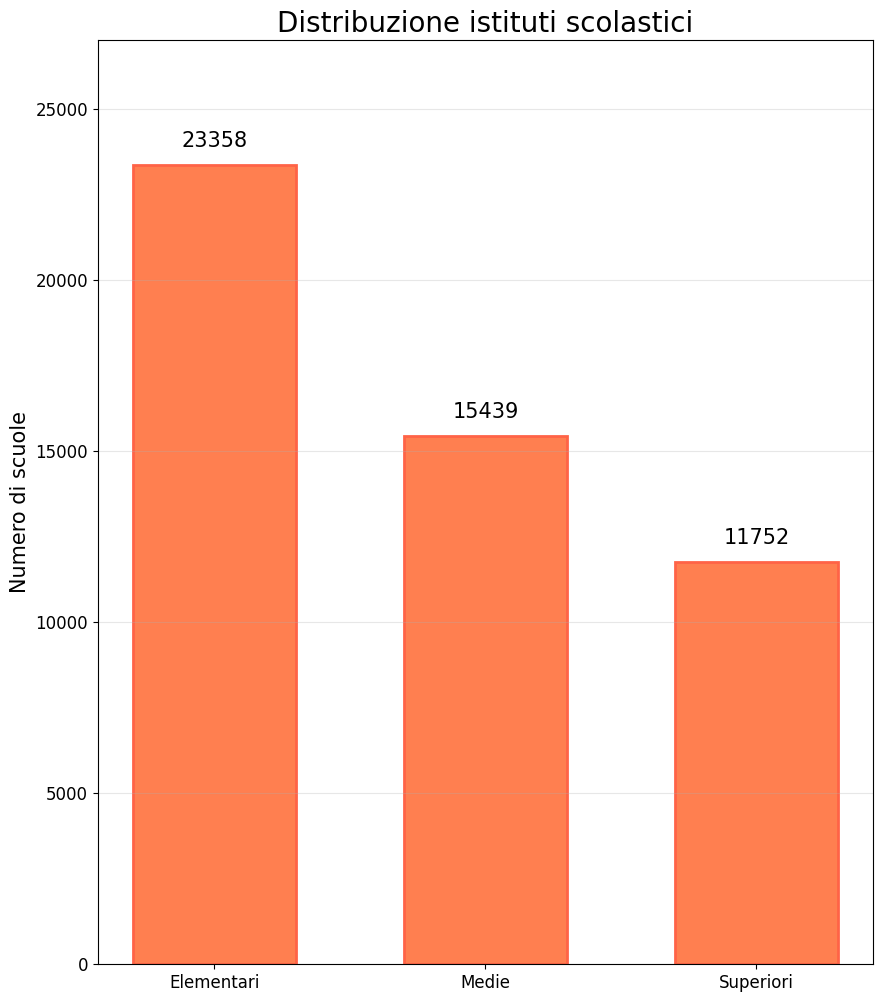

In [8]:
fig, ax = plt.subplots(figsize=(10,12))

plt.ylim([0, 27000])

valori = [len(get_elementari(elenco_scuole)), len(get_medie(elenco_scuole)), len(get_superiori(elenco_scuole))]
plt.title('Distribuzione istituti scolastici', fontsize=20)
plt.ylabel("Numero di scuole", fontsize=15)
plt.grid(alpha=0.3, axis='y')

totale = valori[0] + valori[1] + valori[2]
percentuali = [valori[0] / totale * 100, valori[1] / totale * 100, valori[2] / totale * 100]

bars = plt.bar(tipi_scuole_labels, valori, 0.6, color='coral', edgecolor='tomato', linewidth=2)
#ax.bar_label(bars)
autolabel(bars)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0, 25001, 5000), fontsize=12)

print('percentuali sul totale: elementari + medie + superiori', percentuali)

### Scuole raggiunte da almeno un mezzo nel tempo

In [9]:
def get_scuole_1mezzo(dataset):
    return dataset[(dataset.SCUOLABUS == 'SI') | (dataset.TRASPORTIPUBBLICIURBANI == 'SI') | (dataset.TRASPORTIPUBBLICIINTERURBANI == 'SI') | (dataset.TRASPORTIFERROVIARI == 'SI')]

scuole_1mezzo = get_scuole_1mezzo(t_2122)

scuole_1mezzo_1516 = get_scuole_1mezzo(t_1516)
scuole_1mezzo_1718 = get_scuole_1mezzo(t_1718)
scuole_1mezzo_1819 = get_scuole_1mezzo(t_1819)
scuole_1mezzo_2021 = get_scuole_1mezzo(t_2021)
scuole_1mezzo_2122 = scuole_1mezzo

percentuale_1516 = len(scuole_1mezzo_1516) / len(t_1516) * 100
print(percentuale_1516)

percentuale_1718 = len(scuole_1mezzo_1718) / len(t_1718) * 100
print(percentuale_1718)

percentuale_1819 = len(scuole_1mezzo_1819) / len(t_1819) * 100
print(percentuale_1819)

percentuale_2021 = len(scuole_1mezzo_2021) / len(t_2021) * 100
print(percentuale_2021)

percentuale_2122 = len(scuole_1mezzo_2122) / len(t_2122) * 100
print(percentuale_2122)

82.39311865207463
85.488397563146
85.51108845271476
87.62026729714643
89.52394969664262


## LineChart Temporale

%2015-16= 82.39311865207463 
%2021-22= 89.52394969664262


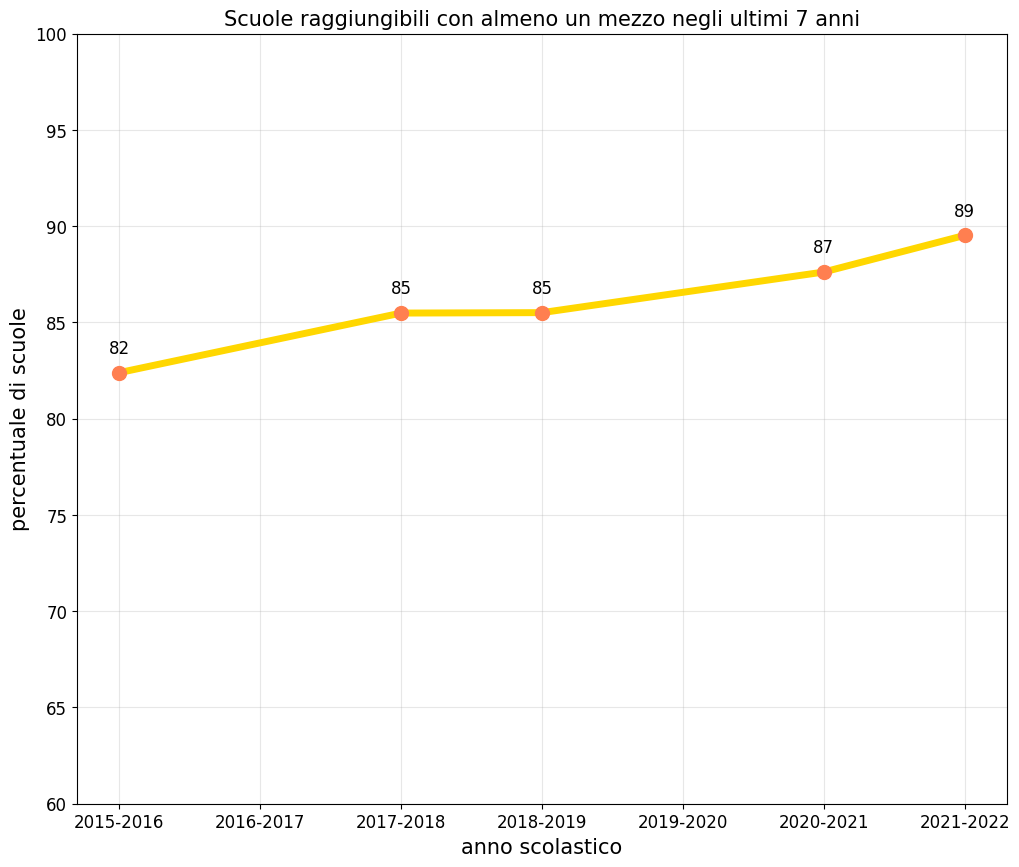

In [10]:
values1 = [percentuale_1516, (percentuale_1718+percentuale_1516)/2, percentuale_1718, percentuale_1819, (percentuale_2021+percentuale_1819)/2, percentuale_2021, percentuale_2122]
values2 = [percentuale_1516, None, percentuale_1718, percentuale_1819, None, percentuale_2021, percentuale_2122]
fig, ax = plt.subplots(figsize=(12,10))
plt.ylim([60, 100])

plt.plot(years_labels, values1, linestyle='-', color='gold', linewidth=5)
plt.plot(years_labels, values2, marker='o', color='coral', linestyle="None", markersize=10)
plt.grid(alpha=0.3)
plt.yticks(np.arange(60, 105, 5), fontsize=12)
plt.ylabel("percentuale di scuole", fontsize=15)
plt.xlabel("anno scolastico", fontsize=15)
plt.xticks(fontsize=12)
print("%2015-16=", percentuale_1516, "\n%2021-22=", percentuale_2122)

plt.title("Scuole raggiungibili con almeno un mezzo negli ultimi 7 anni", fontsize=15)

for i, v in enumerate(values2):
    if v == None: continue
    ax.text(i, v + 1, "%d" %v, ha="center", size = 12)

## Confronto scuole raggiungibili e non raggiungibili con un mezzo

raggiungibili= 89.4292126919861 
non raggiungibili= 10.570787308013905


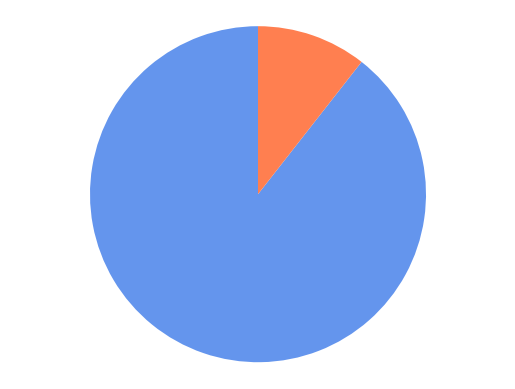

In [11]:
labels = 'raggiungibili con mezzi', ' '
percentuale = len(get_scuole_1mezzo(get_scuole_di_interesse(t_2122))) / len(get_scuole_di_interesse(t_2122)) * 100

sizes = [percentuale, 100-percentuale]

fig1, ax1 = plt.subplots()
#ax1.pie(sizes,  startangle=90, autopct='%1.1f%%', colors=["cornflowerblue", "coral"])
ax1.pie(sizes,  startangle=90, colors=["cornflowerblue", "coral"])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print("raggiungibili=", percentuale, "\nnon raggiungibili=", 100-percentuale)

### Scuole raggiunte dallo scuolabus

In [12]:
scuole_scuolabus = t_2122[t_2122.SCUOLABUS == 'SI']

elementari_scuolabus = get_elementari(scuole_scuolabus)
medie_scuolabus = get_medie(scuole_scuolabus)
superiori_scuolabus = get_superiori(scuole_scuolabus)

In [13]:
percentuali_scuolabus = [
    len(elementari_scuolabus) / len(get_elementari(t_2122)) * 100,
    len(medie_scuolabus) / len(get_medie(t_2122)) * 100,
    len(superiori_scuolabus) / len(get_superiori(t_2122)) * 100
]
percentuale_scuolabus = len(get_scuole_di_interesse(scuole_scuolabus)) / len(get_scuole_di_interesse(t_2122)) * 100

### Scuole raggiunte da trasporti pubblici urbani

In [14]:
scuole_urbano = t_2122[t_2122.TRASPORTIPUBBLICIURBANI == 'SI']

elementari_urbano = get_elementari(scuole_urbano)
medie_urbano = get_medie(scuole_urbano)
superiori_urbano = get_superiori(scuole_urbano)

In [15]:
percentuali_urbano = [
    len(elementari_urbano) / len(get_elementari(t_2122)) * 100,
    len(medie_urbano) / len(get_medie(t_2122)) * 100,
    len(superiori_urbano) / len(get_superiori(t_2122)) * 100
]

percentuale_urbano = len(get_scuole_di_interesse(scuole_urbano)) / len(get_scuole_di_interesse(t_2122)) * 100

### Scuole raggiunte da trasporti pubblici Interurbani

In [16]:
scuole_interurbano = t_2122[t_2122.TRASPORTIPUBBLICIINTERURBANI == 'SI']

elementari_interurbano = get_elementari(scuole_interurbano)
medie_interurbano = get_medie(scuole_interurbano)
superiori_interurbano = get_superiori(scuole_interurbano)

In [17]:
percentuali_interurbano = [
    len(elementari_interurbano) / len(get_elementari(t_2122)) * 100,
    len(medie_interurbano) / len(get_medie(t_2122)) * 100,
    len(superiori_interurbano) / len(get_superiori(t_2122)) * 100
]

percentuale_interurbano = len(get_scuole_di_interesse(scuole_interurbano)) / len(get_scuole_di_interesse(t_2122)) * 100

### Scuole raggiunte da trasporti ferroviari

In [18]:
scuole_ferroviario = t_2122[t_2122.TRASPORTIFERROVIARI == 'SI']

elementari_ferroviario = get_elementari(scuole_ferroviario)
medie_ferroviario = get_medie(scuole_ferroviario)
superiori_ferroviario = get_superiori(scuole_ferroviario)

In [19]:
percentuali_ferroviario = [
    len(elementari_ferroviario) / len(get_elementari(t_2122)) * 100,
    len(medie_ferroviario) / len(get_medie(t_2122)) * 100,
    len(superiori_ferroviario) / len(get_superiori(t_2122)) * 100
]

percentuale_ferroviario = len(get_scuole_di_interesse(scuole_ferroviario)) / len(get_scuole_di_interesse(t_2122)) * 100

### Barchart

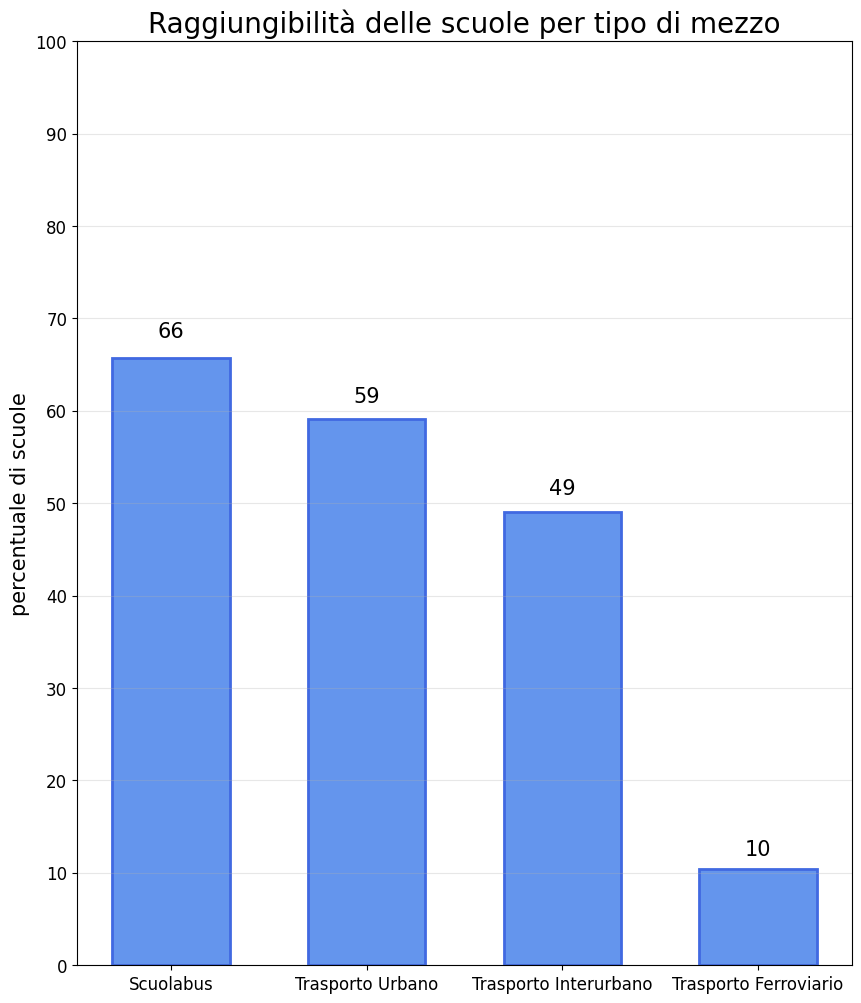

In [20]:
fig, ax = plt.subplots(figsize=(10,12))

plt.ylim([0, 100])

mezzi_labels = ['Scuolabus', 'Trasporto Urbano', 'Trasporto Interurbano', 'Trasporto Ferroviario']
percentuali = [percentuale_scuolabus, percentuale_urbano, percentuale_interurbano, percentuale_ferroviario]
plt.title('Raggiungibilità delle scuole per tipo di mezzo', fontsize=20)
plt.ylabel("percentuale di scuole", fontsize=15)
plt.yticks(np.arange(0, 105, 10), fontsize=12)
plt.xticks( fontsize = 12)
plt.grid(alpha=0.3, axis='y')

bars = plt.bar(mezzi_labels, percentuali, 0.6, color='cornflowerblue', edgecolor='royalblue', linewidth=2)
#ax.bar_label(bars)
autolabel(bars)

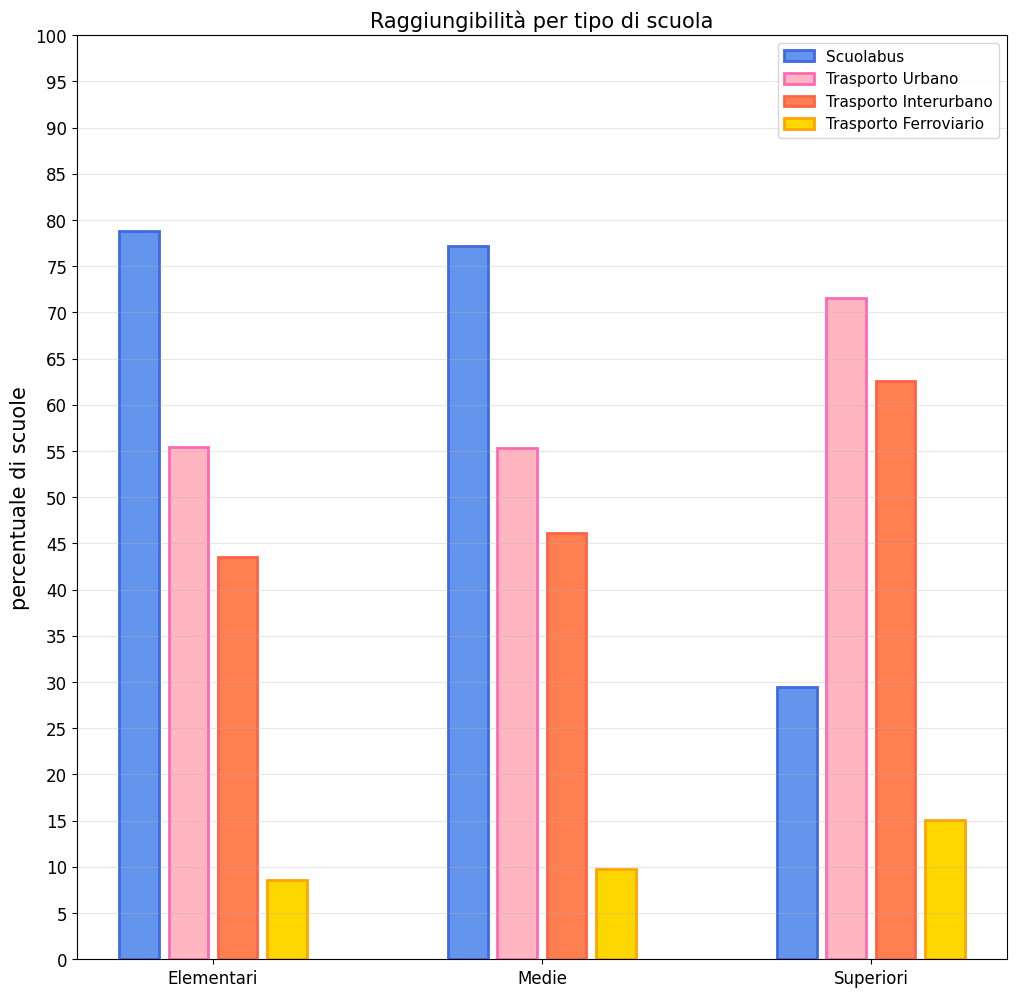

In [35]:
plt.figure(figsize=(12,12))
plt.ylim([0, 100])
width = 0.15
indexes = np.arange(3)
bars1=plt.bar(indexes, percentuali_scuolabus, 0.12, color='cornflowerblue', label='Scuolabus', edgecolor='royalblue', linewidth=2)
bars2=plt.bar(indexes + width, percentuali_urbano, 0.12, color='lightpink', label='Trasporto Urbano', edgecolor='hotpink', linewidth=2)
bars3=plt.bar(indexes + width*2, percentuali_interurbano, 0.12, color='coral', label='Trasporto Interurbano', edgecolor='tomato', linewidth=2)
bars4=plt.bar(indexes + width*3, percentuali_ferroviario, 0.12, color='gold', label='Trasporto Ferroviario', edgecolor='orange', linewidth=2)

plt.ylabel("percentuale di scuole", fontsize=15)
plt.xticks(indexes + width*1.5, tipi_scuole_labels, fontsize = 12)
plt.yticks(np.arange(0, 105, 5), fontsize=12)
plt.grid(alpha=0.3, axis='y')
plt.legend(fontsize=11)
plt.title('Raggiungibilità per tipo di scuola', fontsize=15)

plt.show()

# Cartine

## Cartina 1 Mezzo

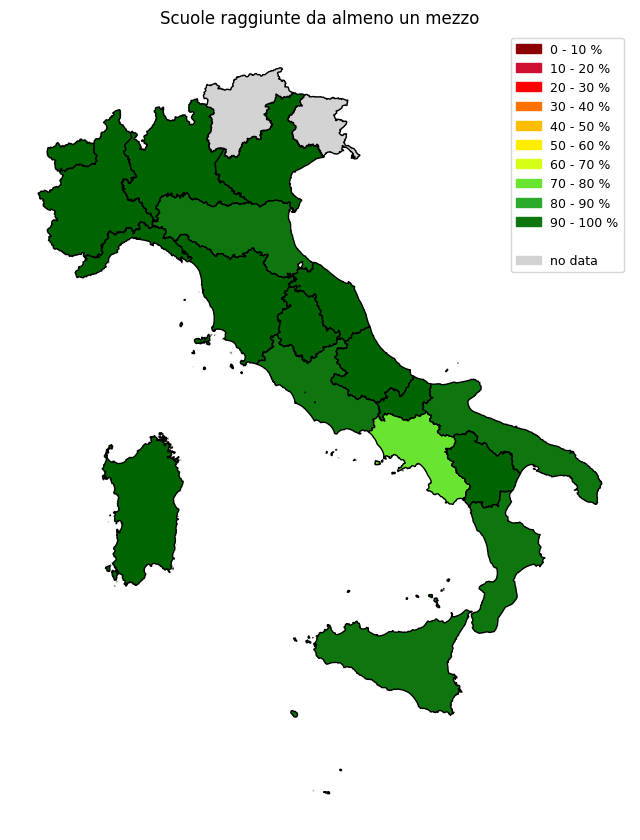

In [22]:
def get_1mezzo_by_region(regione):
    scuole_regione = get_scuole_by_region(
        regione, 
        pd.merge(t_2122, elenco_scuole, on='CODICESCUOLA'), 
        elenco_province
    )
    scuole_regione_1mezzo = get_scuole_1mezzo(get_scuole_di_interesse(scuole_regione))
    if(len(scuole_regione_1mezzo) == 0): return 0
    return len(scuole_regione_1mezzo) / len(get_scuole_di_interesse(scuole_regione)) * 100

cartina(get_1mezzo_by_region, shape_regioni, 'Scuole raggiunte da almeno un mezzo')

### Cartina scuolabus

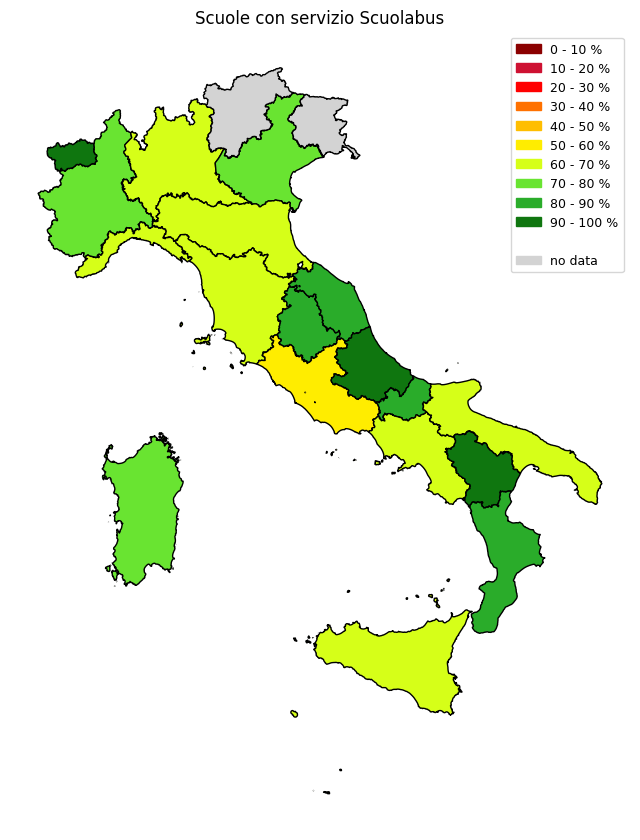

In [23]:
def get_scuolabus_by_region(regione):
    scuole_regione = get_scuole_by_region(
        regione, 
        pd.merge(t_2122, elenco_scuole, on='CODICESCUOLA'), 
        elenco_province
    )
    if(len(scuole_regione) == 0): return 0
    scuole_regione_scuolabus = scuole_regione[scuole_regione.SCUOLABUS == 'SI']
    return len(get_scuole_di_interesse(scuole_regione_scuolabus)) / len(get_scuole_di_interesse(scuole_regione)) * 100

cartina(get_scuolabus_by_region, shape_regioni, 'Scuole con servizio Scuolabus')

### Cartina urbano

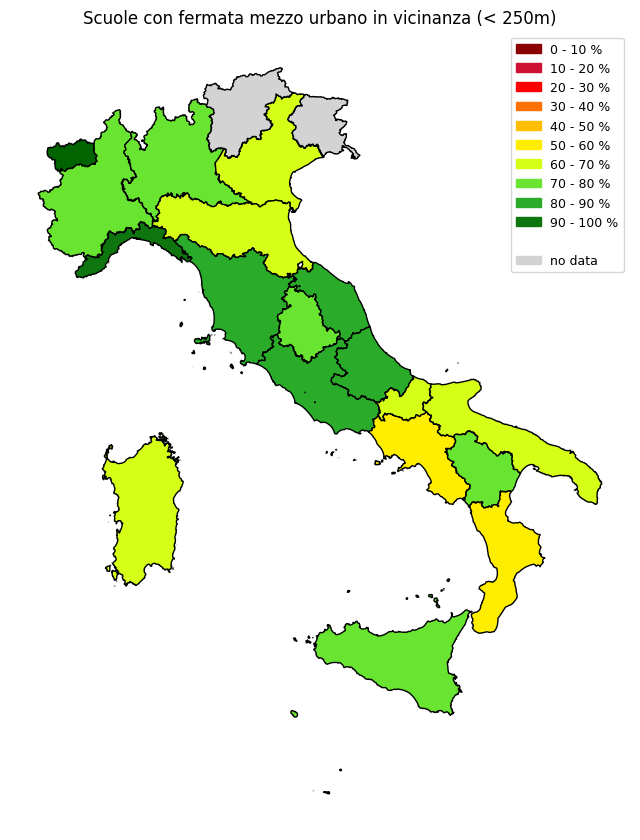

In [24]:
def get_urbano_by_region(regione):
    scuole_regione = get_scuole_by_region(
        regione, 
        pd.merge(t_2122, elenco_scuole, on='CODICESCUOLA'), 
        elenco_province
    )
    if(len(scuole_regione) == 0): return 0
    scuole_regione_urbano = scuole_regione[scuole_regione.TRASPORTIPUBBLICIURBANI == 'SI']
    return len(get_scuole_di_interesse(scuole_regione_urbano)) / len(get_scuole_di_interesse(scuole_regione)) * 100

cartina(get_urbano_by_region, shape_regioni, 'Scuole con fermata mezzo urbano in vicinanza (< 250m)')

### Cartina interurbano

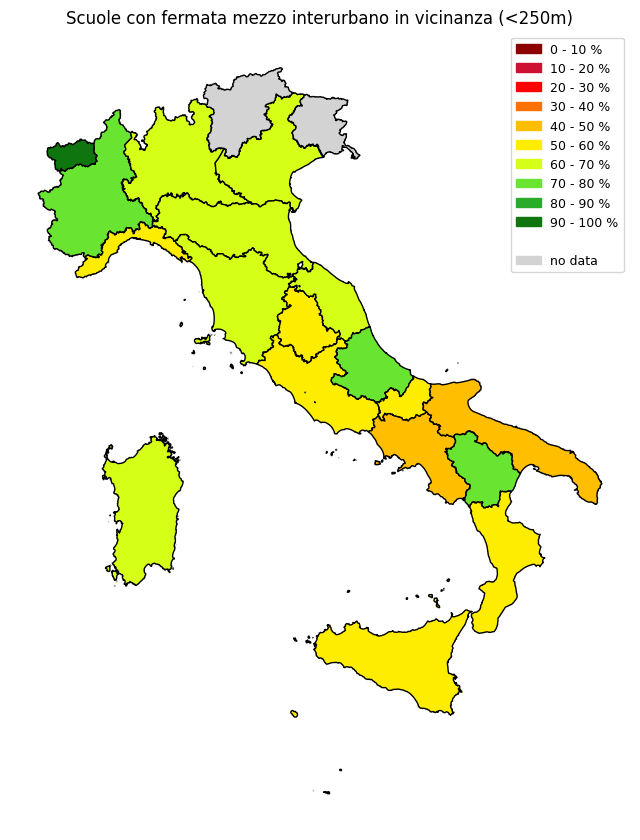

In [25]:
def get_interurbano_by_region(regione):
    scuole_regione = get_scuole_by_region(
        regione, 
        pd.merge(t_2122, elenco_scuole, on='CODICESCUOLA'), 
        elenco_province
    )
    if(len(scuole_regione) == 0): return 0
    scuole_regione_interurbano = scuole_regione[scuole_regione.TRASPORTIPUBBLICIINTERURBANI == 'SI']
    return len(get_scuole_di_interesse(scuole_regione_interurbano)) / len(get_scuole_di_interesse(scuole_regione)) * 100

cartina(get_interurbano_by_region, shape_regioni, 'Scuole con fermata mezzo interurbano in vicinanza (<250m)') 

### Cartina ferroviario

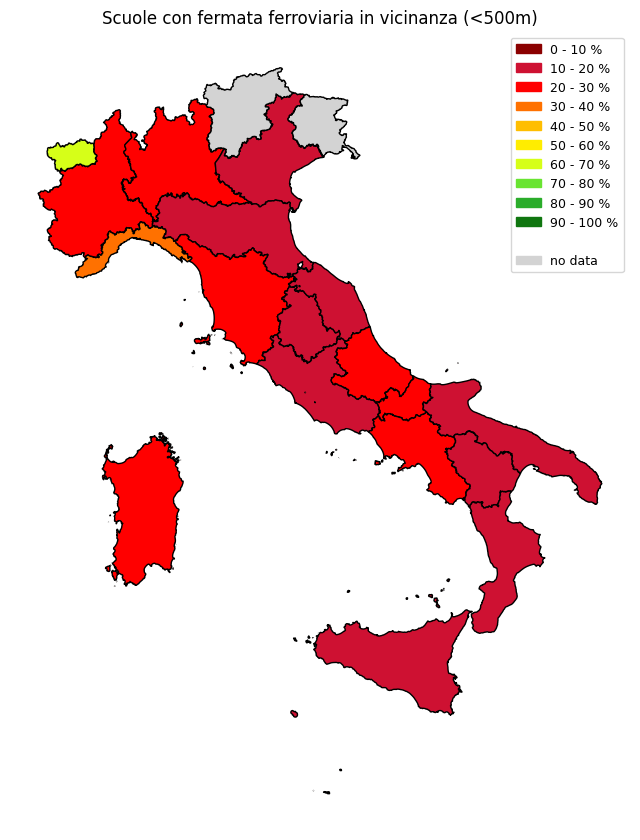

In [26]:
def get_ferroviario_by_region(regione):
    scuole_regione = get_scuole_by_region(
        regione, 
        pd.merge(t_2122, elenco_scuole, on='CODICESCUOLA'), 
        elenco_province
    )
    if(len(scuole_regione) == 0): return 0
    scuole_regione_ferroviario = scuole_regione[scuole_regione.TRASPORTIFERROVIARI == 'SI']
    return len(get_scuole_di_interesse(scuole_regione_ferroviario)) / len(get_scuole_di_interesse(scuole_regione)) * 100

cartina(get_ferroviario_by_region, shape_regioni, 'Scuole con fermata ferroviaria in vicinanza (<500m)')

## Linechart Campania


In [27]:
def get_1mezzo_by_region_year(regione, annata):
    scuole_regione = get_scuole_by_region(
                    regione, 
                    pd.merge(annata, elenco_scuole, on='CODICESCUOLA'),
                    elenco_province )
    
    scuole_regione_1mezzo = get_scuole_1mezzo(scuole_regione)
    return len(get_scuole_di_interesse(scuole_regione_1mezzo)) / len(get_scuole_di_interesse(scuole_regione)) * 100

campania_1516 = get_1mezzo_by_region_year('Campania', t_1516)
campania_1718 = get_1mezzo_by_region_year('Campania', t_1718)
campania_1819 = get_1mezzo_by_region_year('Campania', t_1819)
campania_2021 = get_1mezzo_by_region_year('Campania', t_2021)
campania_2122 = get_1mezzo_by_region_year('Campania', t_2122)

lines = [
    campania_1516, 
    (campania_1718+campania_1516)/2, 
    campania_1718, campania_1819, 
    (campania_2021+campania_1819)/2, 
    campania_2021, campania_2122 ]

dots = [
    campania_1516, 
    None, 
    campania_1718, 
    campania_1819, 
    None, 
    campania_2021, 
    campania_2122 ]

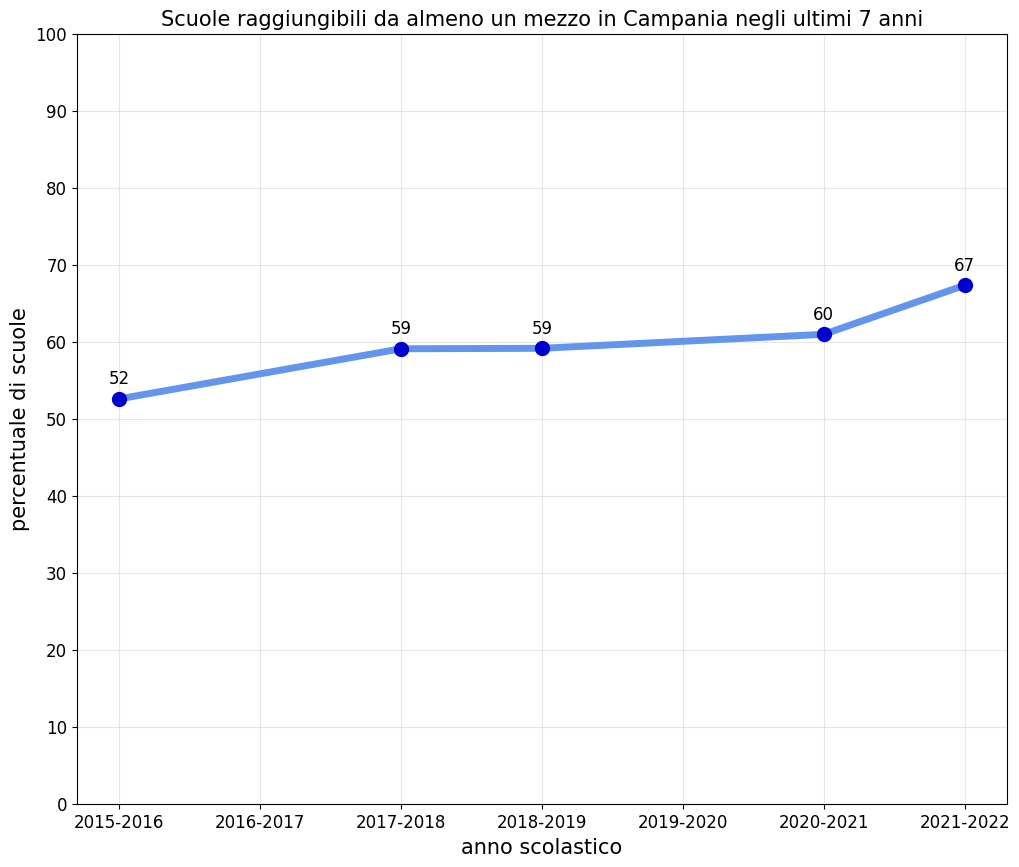

In [28]:
fig, ax = plt.subplots(figsize=(12,10))
plt.ylim([0, 100])

plt.plot(years_labels, lines, linestyle='-', color='cornflowerblue', linewidth=5)
plt.plot(years_labels, dots, marker='o', color='mediumblue', linestyle="None", markersize=10)
plt.grid(alpha=0.3)
plt.yticks(np.arange(0, 105, 10), fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel("percentuale di scuole", fontsize=15)
plt.xlabel("anno scolastico", fontsize=15)
plt.title("Scuole raggiungibili da almeno un mezzo in Campania negli ultimi 7 anni", fontsize=15)

for i, v in enumerate(dots):
    if v == None: continue
    ax.text(i, v + 2, "%d" %v, ha="center", size = 12)

## Confronto tra grafo precedente e quello della Campania

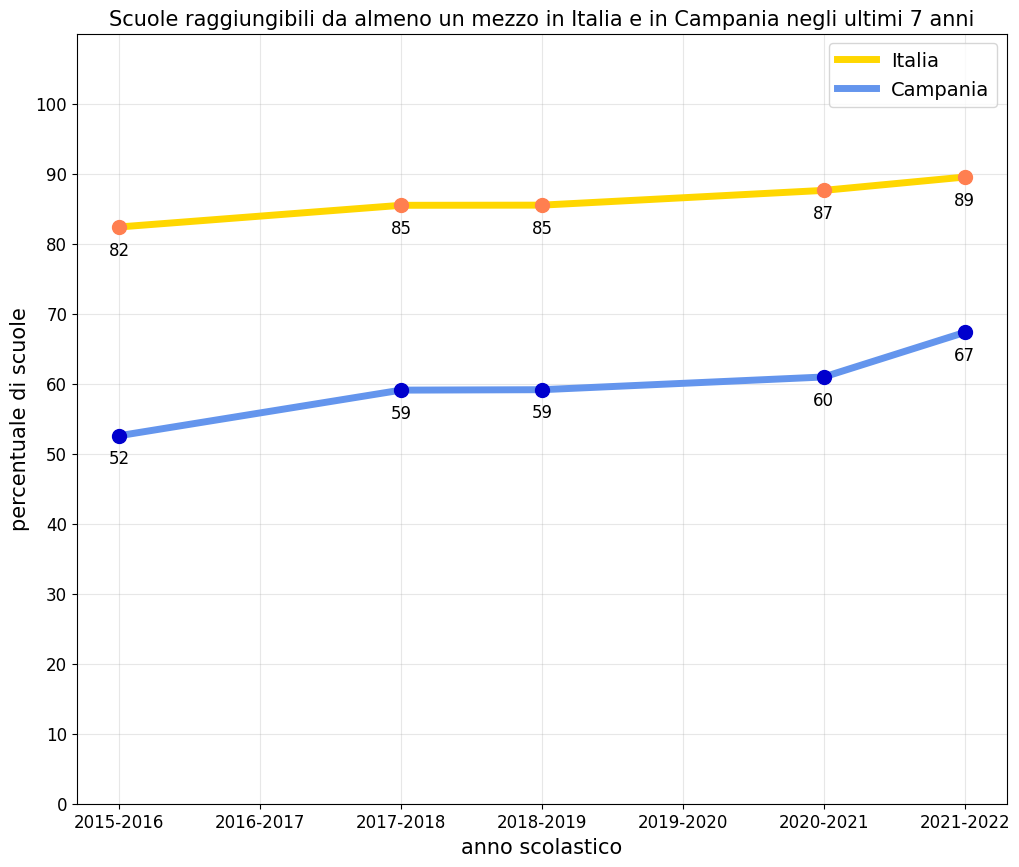

CAMPANIA:
%2015-16= 52.5734225065426 
%2021-22= 67.32594936708861
+ 14.752526860546013 %

MEDIA ITALIA:
%2015-16= 82.39311865207463 
%2021-22= 89.52394969664262
+ 7.130831044567984 %



In [29]:
fig, ax = plt.subplots(figsize=(12,10))
plt.ylim([0, 100])

#media
plt.plot(years_labels, values1, linestyle='-', color='gold', linewidth=5, label='Italia')
plt.plot(years_labels, values2, marker='o', color='coral', linestyle="None", markersize=10)

for i, v in enumerate(values2):
    if v == None: continue
    ax.text(i, v -4, "%d" %v, ha="center", size = 12)

#campania
plt.plot(years_labels, lines, linestyle='-', color='cornflowerblue', linewidth=5, label='Campania')
plt.plot(years_labels, dots, marker='o', color='mediumblue', linestyle="None", markersize=10)
plt.grid(alpha=0.3)
plt.yticks(np.arange(0, 105, 10), fontsize=12)
plt.ylim([0, 110])
plt.xticks(fontsize=12)
plt.ylabel("percentuale di scuole", fontsize=15)
plt.xlabel("anno scolastico", fontsize=15)
plt.legend(fontsize=14)
plt.title("Scuole raggiungibili da almeno un mezzo in Italia e in Campania negli ultimi 7 anni", fontsize=15)

for i, v in enumerate(dots):
    if v == None: continue
    ax.text(i, v - 4, "%d" %v, ha="center", size = 12)

plt.show()
print("CAMPANIA:\n%2015-16=", campania_1516, "\n%2021-22=", campania_2122)
print("+", campania_2122 - campania_1516, "%\n" )

print("MEDIA ITALIA:\n%2015-16=", percentuale_1516, "\n%2021-22=", percentuale_2122)
print("+", percentuale_2122 - percentuale_1516, "%\n" )